In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
%load_ext tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 24.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


0deg

In [6]:
from pathlib import Path
import os.path
image_dir = Path('/content/gdrive/MyDrive/Hasil_Train/Dataset_128/0deg_LED_resized')

90deg

In [ ]:
from pathlib import Path
import os.path
image_dir = Path('/content/gdrive/MyDrive/Hasil_Train/open_noLED_png_resized')

In [7]:
filepath = pd.Series(list(image_dir.glob(r'**/*.png')), name='Filepath').astype(str)
turbidity = pd.Series(filepath.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Turbidity').astype(np.float)

images = pd.concat([filepath, turbidity], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [8]:
images

,Filepath,Turbidity
0,/content/gdrive/MyDrive/Hasil_Train/Dataset_12...,9.45
1,/content/gdrive/MyDrive/Hasil_Train/Dataset_12...,83.25
2,/content/gdrive/MyDrive/Hasil_Train/Dataset_12...,118.00
3,/content/gdrive/MyDrive/Hasil_Train/Dataset_12...,104.30
4,/content/gdrive/MyDrive/Hasil_Train/Dataset_12...,56.40
...,...,...
536,/content/gdrive/MyDrive/Hasil_Train/Dataset_12...,121.25
537,/content/gdrive/MyDrive/Hasil_Train/Dataset_12...,127.90
538,/content/gdrive/MyDrive/Hasil_Train/Dataset_12...,119.70
539,/content/gdrive/MyDrive/Hasil_Train/Dataset_12...,32.10


**PREPARING DATASET**

In [9]:
#train size = 0.9
train_df, test_df = train_test_split(images, train_size=0.9, shuffle=True, random_state=1) #Split into train and test set

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    #vertical_flip=True,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    #vertical_flip=True,
    horizontal_flip=True
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 389 validated image filenames.
Found 97 validated image filenames.
Found 55 validated image filenames.


**CREATING THE MODEL**

Model Architecture

In [12]:
def get_model():
    #Create model
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet", 
                                                input_shape=(224, 224, 3), pooling='avg')
    out = base_model.output
    prediction = tf.keras.layers.Dense(1, activation="linear")(out)
    model = tf.keras.Model(inputs = base_model.input, outputs = prediction)

    #Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-3 / 1000)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt,
                  metrics=['mse','mae', tfa.metrics.RSquare(name="R2")])
    
    return model

model = get_model()
tf.test.gpu_device_name()

16719872/16705208 [==============================] - 0s 0us/step


'/device:GPU:0'

Training Callbacks

In [13]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
        
earlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5,
    restore_best_weights=True)

class CustomModelCheckpointCallback(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, ignore_first, *args, **kwargs):
      super(CustomModelCheckpointCallback, self).__init__(*args, **kwargs)
      self.ignore_first = ignore_first

    def on_epoch_end(self, epoch, logs):
        if epoch+1> self.ignore_first:
            super().on_epoch_end(epoch, logs)

pathname = 'saved_model/efficientnet-epoch{epoch:02d}-loss{val_loss:.2f}'
checkpoint = CustomModelCheckpointCallback(
    ignore_first=85, filepath = pathname,
    monitor='val_loss', mode='min',
    save_best_only=True, save_freq='epoch')

Training Model

In [14]:
num_epoch = 100
history = model.fit(train_images, validation_data=val_images, 
                    epochs=num_epoch, batch_size=8, callbacks=[tensorboard_callback, checkpoint], verbose=1)

Epoch 1/100
13/13 [==============================] - 366s 27s/step - loss: 26.1751 - mse: 1422.5215 - mae: 26.6696 - R2: -0.0666 - val_loss: 28.5741 - val_mse: 1280.2809 - val_mae: 29.0652 - val_R2: -0.0105
Epoch 2/100
13/13 [==============================] - 6s 468ms/step - loss: 13.2818 - mse: 314.8764 - mae: 13.7762 - R2: 0.7639 - val_loss: 24.1734 - val_mse: 852.4317 - val_mae: 24.6645 - val_R2: 0.3272
Epoch 3/100
13/13 [==============================] - 6s 473ms/step - loss: 10.1604 - mse: 209.8233 - mae: 10.6491 - R2: 0.8427 - val_loss: 31.8136 - val_mse: 1346.3794 - val_mae: 32.3126 - val_R2: -0.0627
Epoch 4/100
13/13 [==============================] - 6s 470ms/step - loss: 8.8982 - mse: 142.5674 - mae: 9.3882 - R2: 0.8931 - val_loss: 34.6367 - val_mse: 1613.6461 - val_mae: 35.1367 - val_R2: -0.2736
Epoch 5/100
13/13 [==============================] - 6s 472ms/step - loss: 6.6024 - mse: 90.3140 - mae: 7.0852 - R2: 0.9323 - val_loss: 27.1444 - val_mse: 1007.8216 - val_mae: 27.644

Save Model Manually

In [15]:
last_val_loss = history.history['val_loss'][-1]
name = f'efficientnet-epoch{num_epoch}-loss{last_val_loss}'
model.save(f"saved_model/{name}")
hist_df = pd.DataFrame(history.history)
hist_csv_file = f'saved_model/{name}/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
#tf.keras.utils.plot_model(model, f"saved_model/{name}/resnet_model_arch.png", show_shapes=False)

INFO:tensorflow:Assets written to: saved_model/efficientnet-epoch100-loss3.29421329498291/assets


In [16]:
print(history.history['val_loss'])

[28.574085235595703, 24.17340087890625, 31.813573837280273, 34.63669967651367, 27.144399642944336, 29.69904327392578, 27.278892517089844, 28.340112686157227, 27.625518798828125, 24.702863693237305, 26.7801456451416, 29.503868103027344, 31.6396427154541, 33.45534133911133, 28.263507843017578, 24.11503028869629, 22.461719512939453, 23.949928283691406, 31.72836685180664, 26.665632247924805, 24.00762939453125, 19.360498428344727, 21.110212326049805, 24.51004409790039, 18.476966857910156, 14.07416820526123, 19.735023498535156, 18.45985221862793, 16.49036407470703, 12.58159351348877, 13.713790893554688, 19.225845336914062, 14.729635238647461, 16.403972625732422, 11.099888801574707, 13.835274696350098, 13.499909400939941, 13.353368759155273, 13.617045402526855, 18.454914093017578, 8.476783752441406, 8.21426010131836, 3.2982826232910156, 8.660699844360352, 5.61868143081665, 5.646139144897461, 8.052206993103027, 5.5323920249938965, 9.163158416748047, 7.760455131530762, 3.7328941822052, 4.855406

Model Evaluation

In [ ]:
%tensorboard --logdir logs

In [17]:

train_pred = np.squeeze(model.predict(train_images))
train_true = train_images.labels
train_residuals = train_true - train_pred

test_pred = np.squeeze(model.predict(test_images))
test_true = test_images.labels
test_residuals = test_true - test_pred

In [21]:
from sklearn.metrics import mean_absolute_error as MAE
MAE_train = MAE(train_true,train_pred)
MAE_test = MAE(test_true,test_pred)
print(MAE_train)
print(MAE_test)

3.8256789110696716
4.2568502976677625


In [22]:
from sklearn.metrics import r2_score as r2
r2_train = r2(train_true,train_pred)
r2_test = r2(test_true,test_pred)
print(r2_train)
print(r2_test)

0.9837027541318614
0.978729129221232


In [23]:
from sklearn.metrics import mean_squared_error as MSE
MSE_train = MSE(train_true,train_pred)
MSE_test = MSE(test_true,test_pred)
print(MSE_train)
print(MSE_test)

21.735777065362164
27.711280151302905


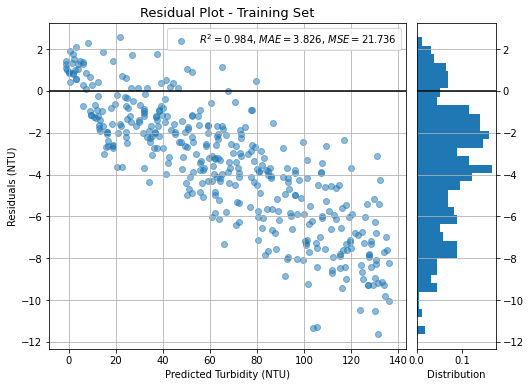

In [34]:
f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [9, 2]})

axs[0].scatter(train_pred,train_residuals, label=f'$R^2=${round(r2_train,3)}, $MAE=${round(MAE_train,3)}, $MSE=${round(MSE_train,3)}', alpha=0.5, color='tab:blue')
axs[0].set_title('Residual Plot - Training Set', fontsize=13)           
axs[0].set_ylabel('Residuals (NTU)', fontsize=10)
axs[0].set_xlabel('Predicted Turbidity (NTU)', fontsize=10)      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(train_residuals, bins=35, orientation="horizontal", density=True)
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution', fontsize=10)  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)
#plt.savefig(f'saved_model/{name}/ResidualPlotTrain_{name}.png', dpi=300)
plt.show()

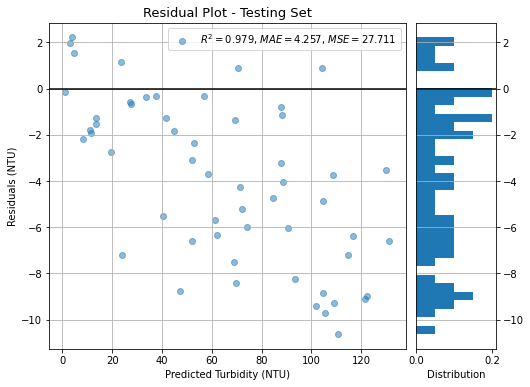

In [33]:
f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [9, 2]})

axs[0].scatter(test_pred,test_residuals, label=f'$R^2=${round(r2_test,3)}, $MAE=${round(MAE_test,3)}, $MSE=${round(MSE_test,3)}', alpha=0.5, color='tab:blue')
axs[0].set_title('Residual Plot - Testing Set', fontsize=13)           
axs[0].set_ylabel('Residuals (NTU)', fontsize=10)
axs[0].set_xlabel('Predicted Turbidity (NTU)', fontsize=10)      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(test_residuals, bins=35, orientation="horizontal", density=True)
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution', fontsize=10)  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)
plt.savefig(f'saved_model/{name}/ResidualPlotTest_{name}.png', dpi=300)
plt.show()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
ma_error = history.history['mae']
val_ma_error = history.history['val_mae']
r2 = history.history['R2']
val_r2 = history.history['val_R2']
ms_error = history.history['mse']
val_ms_error = history.history['val_mse']

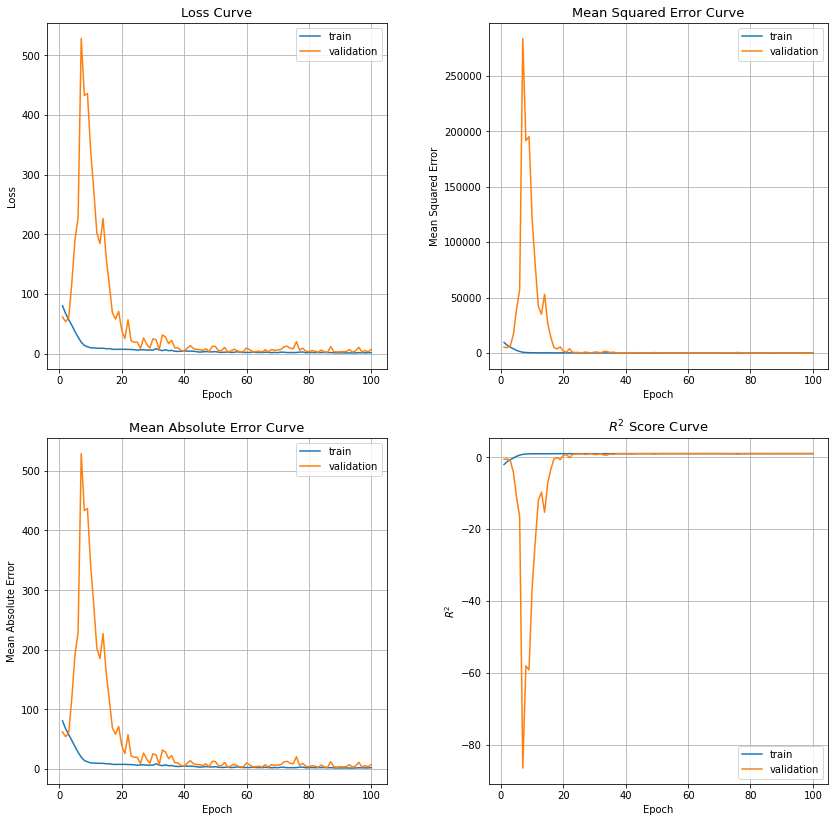

In [ ]:
epochs = range(1, len(loss) + 1)

f, axs = plt.subplots(2, 2, figsize=(14,14))

axs[0][0].plot(epochs, loss, 'tab:blue', label='train')
axs[0][0].plot(epochs, val_loss, 'tab:orange', label='validation')
axs[0][0].set_title('Loss Curve', fontsize=13)
axs[0][0].set_xlabel('Epoch', fontsize=10)
axs[0][0].set_ylabel('Loss', fontsize=10)
axs[0][0].legend()
axs[0][0].grid()

axs[0][1].plot(epochs, ms_error, 'tab:blue', label='train')
axs[0][1].plot(epochs, val_ms_error, 'tab:orange', label='validation')
axs[0][1].set_title('Mean Squared Error Curve', fontsize=13)
axs[0][1].set_xlabel('Epoch')
axs[0][1].set_ylabel('Mean Squared Error')
axs[0][1].legend()
axs[0][1].grid()

axs[1][0].plot(epochs, ma_error, 'tab:blue', label='train')
axs[1][0].plot(epochs, val_ma_error, 'tab:orange', label='validation')
axs[1][0].set_title('Mean Absolute Error Curve', fontsize=13)
axs[1][0].set_xlabel('Epoch')
axs[1][0].set_ylabel('Mean Absolute Error')
axs[1][0].legend()
axs[1][0].grid()

axs[1][1].plot(epochs, r2, 'tab:blue', label='train')
axs[1][1].plot(epochs, val_r2, 'tab:orange', label='validation')
axs[1][1].set_title(r'$R^2$ Score Curve', fontsize=13)
axs[1][1].set_xlabel('Epoch')
axs[1][1].set_ylabel(r'$R^2$')
axs[1][1].legend()
axs[1][1].grid()

#plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig(f'saved_model/{name}/TrainCurve_{name}.png', dpi=300)
plt.show()

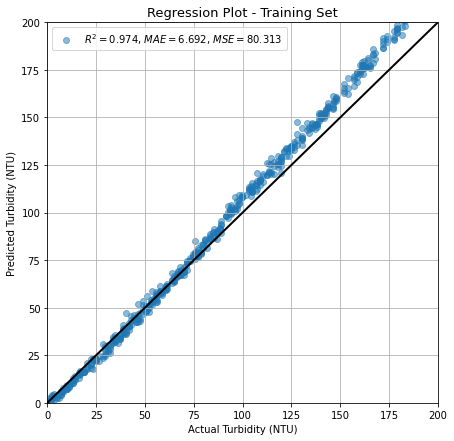

In [ ]:
fig, ax = plt.subplots(1,figsize=(7,7))

ax.scatter(train_true,train_pred, label=f'$R^2=${round(r2_train,3)}, $MAE=${round(MAE_train,3)}, $MSE=${round(MSE_train,3)}', color='tab:blue', alpha=0.5)
theta = np.polyfit(train_true, train_pred, 1)
y_line = theta[1] + theta[0] * train_true
ax.plot([train_true.min(), train_true.max()], [train_true.min(),train_true.max()], 'k-', lw=2)
ax.set_xlabel('Actual Turbidity (NTU)', fontsize=10)
ax.set_ylabel('Predicted Turbidity (NTU)', fontsize=10)
ax.set_title(f'Regression Plot - Training Set', fontsize=13)
ax.set_xlim([0, 200])
ax.set_ylim([0, 200])
ax.grid()
ax.legend()

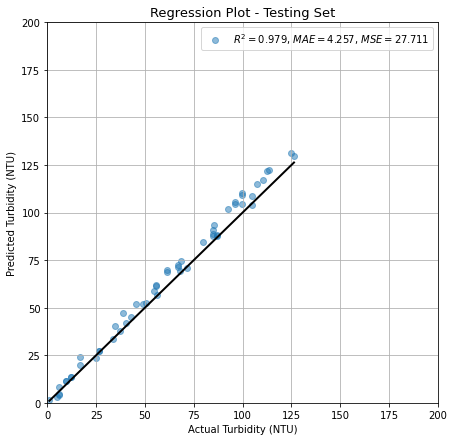

In [35]:
fig, ax = plt.subplots(1,figsize=(7,7))

ax.scatter(test_true,test_pred, label = f'$R^2=${round(r2_test,3)}, $MAE=${round(MAE_test,3)}, $MSE=${round(MSE_test,3)}', color='tab:blue', alpha=0.5)
theta2 = np.polyfit(test_true, test_pred, 1)
y_line2 = theta2[1] + theta2[0] * test_true
ax.plot([test_true.min(), test_true.max()], [test_true.min(), test_true.max()], 'k-', lw=2)
ax.set_xlabel('Actual Turbidity (NTU)', fontsize=10)
ax.set_ylabel('Predicted Turbidity (NTU)', fontsize=10)
ax.set_title(f'Regression Plot - Testing Set', fontsize=13)
ax.set_xlim([0, 200])
ax.set_ylim([0, 200])
ax.grid()
ax.legend()

Copy to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

save_path = f"/content/gdrive/MyDrive/Hasil_Train/Training/EfficientNetB0-Train0.9-Val0.2-TL"
if not os.path.exists(save_path):
  os.makedirs(save_path)

oripath = "saved_model/."
!cp -a "{oripath}" "{save_path}" # copies files to google drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
